In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm      #for regression modelling
from scipy import stats           #for kendal tau
from sklearn import linear_model  #for cross-validation
from sklearn import model_selection
from libpysal import weights
from libpysal import cg as geometry

from shapely.geometry import Polygon
from shapely.wkt import loads  #needed to set geopandas geometry

import matplotlib.pyplot as plt
import palettable.colorbrewer.sequential as pcs  #for colorBrewer palettes
import seaborn as sns

import os
import urllib
import zipfile
import re
import pysal as ps
from pysal.model.spreg import OLS
from pysal.model.spreg import ML_Error
from pysal.model.spreg import ML_Lag

import libpysal as lps
from libpysal.weights import Queen, Rook
import pysal.viz as viz
%matplotlib inline
import warnings
warnings.simplefilter('ignore')


In [12]:
newestcrime = pd.read_csv("/Users/mahnoorshahzad/Documents/a3_year/newestcrime.csv")

In [13]:
imd_df = pd.read_csv("/Users/mahnoorshahzad/Documents/a3_year/ASDS/IMD_ward.csv")

In [14]:
lsoa_df = pd.read_csv("/Users/mahnoorshahzad/Documents/a3_year/ASDS/LSOA_Data.csv")

In [15]:
newestcrime = newestcrime.rename(columns={'avg_2020.1': 'avg_2021'})

In [16]:
crimelsoa_map = pd.merge(lsoa_df, newestcrime, on='LSOA11CD', left_index=False)

In [17]:
crime_imd_lsoa = pd.merge(crimelsoa_map, imd_df, on='LSOA11CD', left_index=False)

In [18]:
crime_imd_lsoa['geometry'] = crime_imd_lsoa['geometry'].apply(lambda x: loads(x)) 
gdf = crime_imd_lsoa.set_geometry('geometry')

In [19]:
crimelsoa_map['geometry'] = crimelsoa_map['geometry'].apply(lambda x: loads(x)) 
gdf2 = crimelsoa_map.set_geometry('geometry')

In [20]:
import esda
import pysal

In [21]:
w = weights.KNN.from_dataframe(gdf, k=8) 
w.transform = 'R'
moran = esda.moran.Moran(gdf['avg_2021'], w)

In [22]:
gdf['avg_2021'].median()

3.25

In [23]:
binary = gdf['avg_2021']> gdf['avg_2021'].median()
sum(binary)

2244

In [24]:
labels = ['Low Price', 'High Price']
binary = [labels[i] for i in 1*binary] 
gdf['binary'] = binary

<AxesSubplot:>

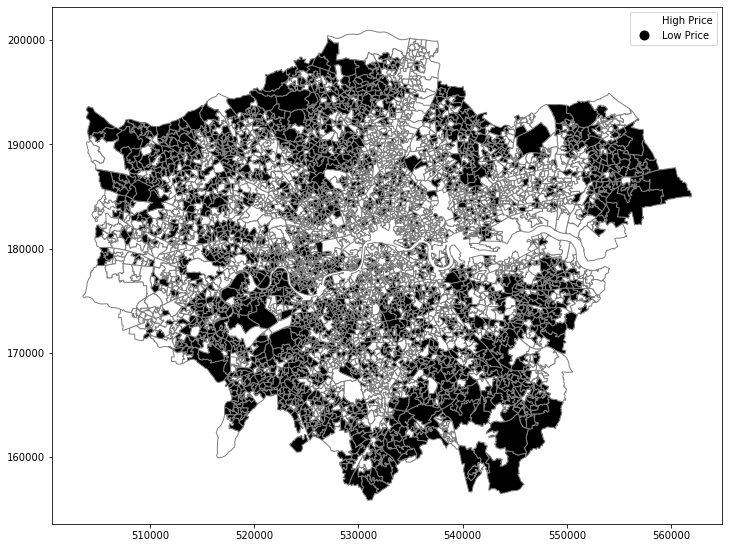

In [25]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
gdf.plot(column='binary', cmap='binary', edgecolor='grey', legend=True, ax=ax)

In [26]:
w_queen = lps.weights.KNN.from_dataframe(gdf)

In [28]:
from pysal.explore import esda 
binary = 1 * (gdf2['avg_2021']> gdf2['avg_2021'].median()) # convert back to binary
w_KNN = lps.weights.KNN.from_dataframe(gdf2)
w_queen.transform = 'R'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(binary, w_KNN)

In [29]:
jc.bb

1492.5

In [30]:
jc.ww

1629.5

In [31]:
jc.bw

1707.0

In [32]:
jc.bb + jc.ww + jc.bw

4829.0

In [33]:
jc.p_sim_bb

0.001

In [34]:
w_KNN.s0 / 2

4829.0

In [35]:
mi = esda.moran.Moran(gdf2['avg_2021'], w_KNN) # call moran function
mi.I # print out the moran's I value

0.292488178097135

Text(0.5, 0, "Moran's I")

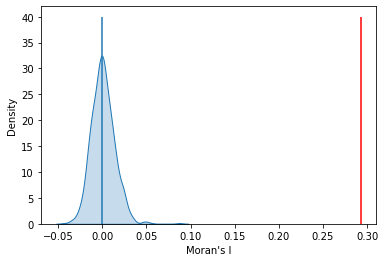

In [36]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 40, color='r')
plt.vlines(mi.EI, 0, 40)
plt.xlabel("Moran's I")

In [37]:
mi.p_sim

0.001

In [38]:
lisa = ps.explore.esda.Moran_Local(gdf2['avg_2021'].values, w_KNN, permutations=999)
lisa.Is

array([-0.37679091,  0.81245046,  0.06183056, ..., -0.14480877,
       -0.06986174, -0.19611353])

In [39]:
lisa.q

array([2, 1, 1, ..., 4, 2, 2])

In [40]:
lisa.p_sim

array([0.086, 0.2  , 0.296, ..., 0.162, 0.136, 0.241])

In [41]:
(lisa.p_sim < 0.05).sum()

643

In [42]:
from pysal import lib

In [43]:
gdf2['lag_avg'] = ps.lib.weights.lag_spatial(w_KNN, gdf2['avg_2021'])
sigs = gdf2['avg_2021'][lisa.p_sim <= .05]
W_sigs = gdf2['lag_avg'][lisa.p_sim <= .05]
insigs = gdf2['avg_2021'][lisa.p_sim > .05]
W_insigs = gdf2['lag_avg'][lisa.p_sim > .05]

In [44]:
gdf2['lag_avg'] = ps.lib.weights.lag_spatial(w_KNN, gdf2['avg_2020'])
sigs = gdf2['avg_2020'][lisa.p_sim <= .05]
W_sigs = gdf2['lag_avg'][lisa.p_sim <= .05]
insigs = gdf2['avg_2020'][lisa.p_sim > .05]
W_insigs = gdf2['lag_avg'][lisa.p_sim > .05]

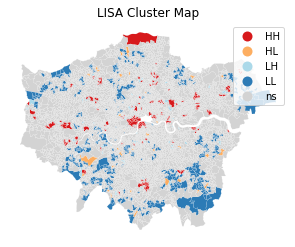

In [45]:
from splot.esda import lisa_cluster
fig = lisa_cluster(lisa, gdf2)
plt.title("LISA Cluster Map")
plt.show()

In [46]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3
doughnut = sig * lisa.q==2
diamond = sig * lisa.q==4

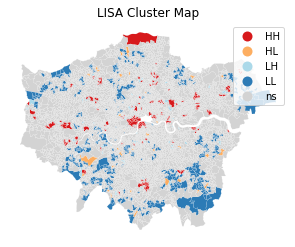

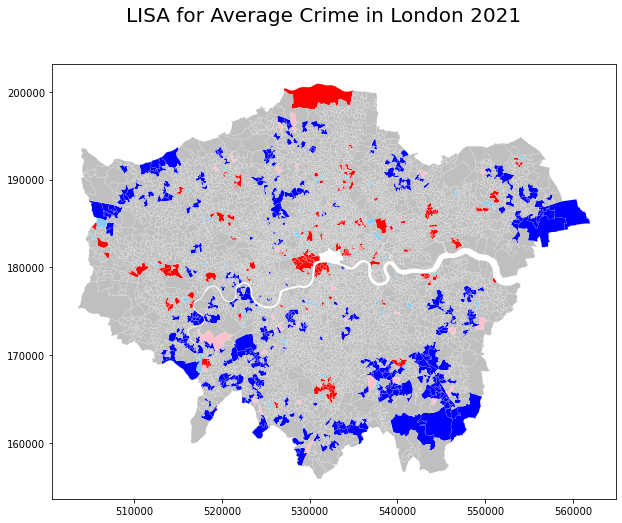

In [49]:
f, ax = plt.subplots(1, figsize=(12, 8))
# Plot building blocks
gdf2.plot(ax=ax, facecolor='1', linewidth=0.1)
# Plot HH clusters
hh = gdf2.loc[(lisa.q==1) & (sig==True), 'geometry']
hh.plot(ax=ax, color='red', linewidth=0.1, edgecolor='w')
# Plot LL clusters
ll = gdf2.loc[(lisa.q==3) & (sig==True), 'geometry']
ll.plot(ax=ax, color='blue', linewidth=0.1, edgecolor='w')
# Plot LH clusters
lh = gdf2.loc[(lisa.q==2) & (sig==True), 'geometry']
lh.plot(ax=ax, color='#83cef4', linewidth=0.1, edgecolor='w')
# Plot HL clusters
hl = gdf2.loc[(lisa.q==4) & (sig==True), 'geometry']
hl.plot(ax=ax, color='pink', linewidth=0.1, edgecolor='w')
# Non-significant
ns = gdf2.loc[sig!=True, 'geometry']
ns.plot(ax=ax, color='0.75', linewidth=0.1, edgecolor='w')
# Style and draw
f.suptitle('LISA for Average Crime in London', size=20)
f.set_facecolor('w')
plt.show()

array([[<AxesSubplot:title={'center':'avg_2021'}>]], dtype=object)

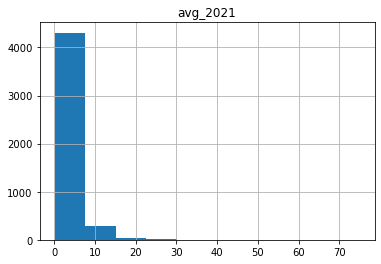

In [51]:
gdf.hist('avg_2021')

array([[<AxesSubplot:title={'center':'imd_score'}>]], dtype=object)

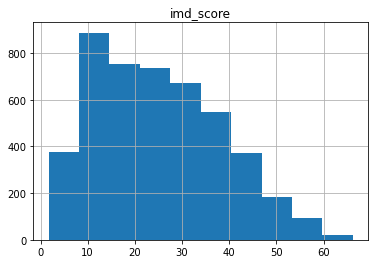

In [52]:
gdf.hist('imd_score')

array([[<AxesSubplot:title={'center':'POPDEN'}>]], dtype=object)

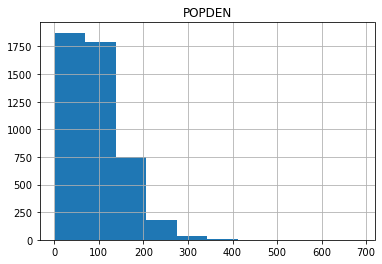

In [53]:
gdf.hist('POPDEN')

array([[<AxesSubplot:title={'center':'RoadsArea'}>]], dtype=object)

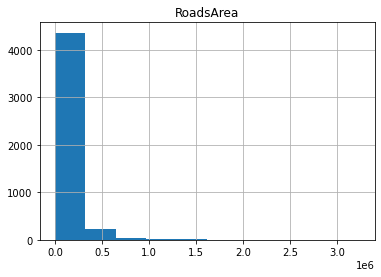

In [54]:
gdf.hist('RoadsArea')

array([[<AxesSubplot:title={'center':'MeanPrice'}>]], dtype=object)

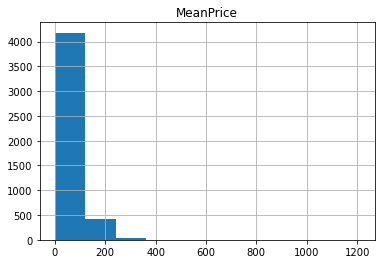

In [55]:
gdf.hist('MeanPrice')

array([[<AxesSubplot:title={'center':'AVHHOLDSZ'}>]], dtype=object)

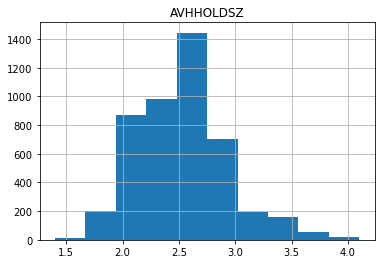

In [56]:
gdf.hist('AVHHOLDSZ')

In [57]:
gdf['logavg_2021'] = np.log(gdf['avg_2021'])
gdf['sqimd_score'] = np.sqrt(gdf['imd_score'])
gdf['sqPOPDEN'] = np.sqrt(gdf['POPDEN'])
gdf['sqRoadsArea'] = np.sqrt(gdf['RoadsArea'])
gdf['sqMeanPrice'] = np.sqrt(gdf['MeanPrice'])

In [58]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
y, X = dmatrices('logavg_2021 ~  sqimd_score +AVHHOLDSZ  + sqRoadsArea + sqPOPDEN + sqMeanPrice', data=gdf, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

 
vif

VIF     variable
0  81.367812    Intercept
1   1.322532  sqimd_score
2   1.148820    AVHHOLDSZ
3   1.207340  sqRoadsArea
4   1.625893     sqPOPDEN
5   1.231487  sqMeanPrice

In [59]:
mod_dlc = sm.OLS.from_formula("avg_2021 ~ imd_score ", data = gdf) 
mod_dlc_RR = mod_dlc.fit()
print(mod_dlc_RR.summary())

                            OLS Regression Results                            
Dep. Variable:               avg_2021   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sun, 22 May 2022   Prob (F-statistic):          4.95e-199
Time:                        04:11:14   Log-Likelihood:                -11531.
No. Observations:                4638   AIC:                         2.307e+04
Df Residuals:                    4636   BIC:                         2.308e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2843      0.092     14.005      0.0

In [60]:
crime = gdf['logavg_2021']
y = np.array(crime)
y.shape = (len(crime),1)

X= []
X.append(gdf['AVHHOLDSZ']) 
X.append(gdf['sqimd_score'])
X.append(gdf['sqRoadsArea']) 
X.append(gdf['sqPOPDEN']) 
X.append(gdf['sqMeanPrice']) 

X = np.array(X).T

In [61]:
m1 = OLS(y, X, name_y='logavg_2021',
         name_x=['AVHHOLDSZ','sqimd_score','sqRoadsArea', 'sqPOPDEN', 'sqMeanPrice'], 
         name_ds='gdf')
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :         gdf
Weights matrix      :        None
Dependent Variable  : logavg_2021                Number of Observations:        4638
Mean dependent var  :      1.1194                Number of Variables   :           6
S.D. dependent var  :      0.6808                Degrees of Freedom    :        4632
R-squared           :      0.4761
Adjusted R-squared  :      0.4755
Sum squared residual:    1125.926                F-statistic           :    841.8144
Sigma-square        :       0.243                Prob(F-statistic)     :           0
S.E. of regression  :       0.493                Log likelihood        :   -3298.080
Sigma-square ML     :       0.243                Akaike info criterion :    6608.160
S.E of regression ML:      0.4927                Schwarz criterion     :    6646.812

-----------------------------------------------------------------------------

In [62]:
spat_lag = ML_Lag(y,X,w_queen,name_y='logavg_2021', 
                  name_x=['AVHHOLDSZ','sqimd_score','sqRoadsArea', 'sqPOPDEN', 'sqMeanPrice'],
                  name_w='w_queen',
                  name_ds='gdf')
print(spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :         gdf
Weights matrix      :     w_queen
Dependent Variable  : logavg_2021                Number of Observations:        4638
Mean dependent var  :      1.1194                Number of Variables   :           7
S.D. dependent var  :      0.6808                Degrees of Freedom    :        4631
Pseudo R-squared    :      0.4994
Spatial Pseudo R-squared:  0.4667
Sigma-square ML     :       0.232                Log likelihood        :   -3217.621
S.E of regression   :       0.482                Akaike info criterion :    6449.241
                                                 Schwarz criterion     :    6494.336

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [63]:
spat_err = ML_Error(y,X,w_queen, name_y='logavg_2021', 
                    name_x=['AVHHOLDSZ','sqimd_score','sqRoadsArea', 'sqPOPDEN', 'sqMeanPrice'], 
                    name_w='w_queen', name_ds='gdf')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :         gdf
Weights matrix      :     w_queen
Dependent Variable  : logavg_2021                Number of Observations:        4638
Mean dependent var  :      1.1194                Number of Variables   :           6
S.D. dependent var  :      0.6808                Degrees of Freedom    :        4632
Pseudo R-squared    :      0.4752
Sigma-square ML     :       0.223                Log likelihood        :   -3161.542
S.E of regression   :       0.473                Akaike info criterion :    6335.084
                                                 Schwarz criterion     :    6373.737

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

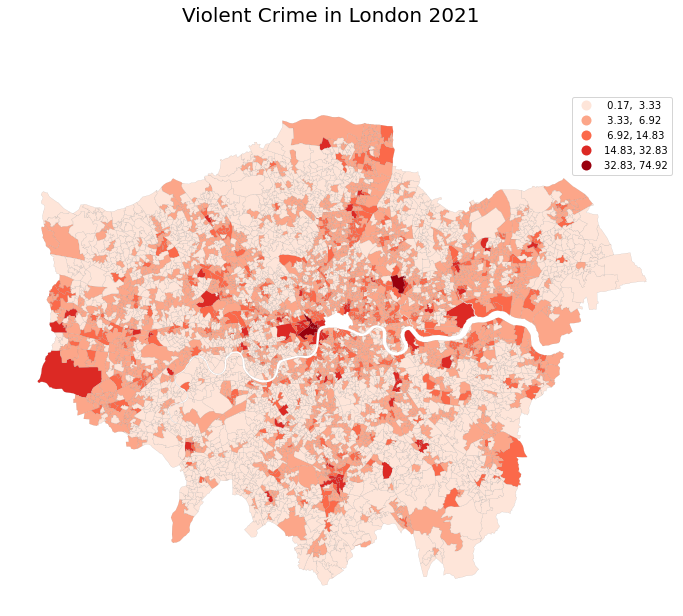

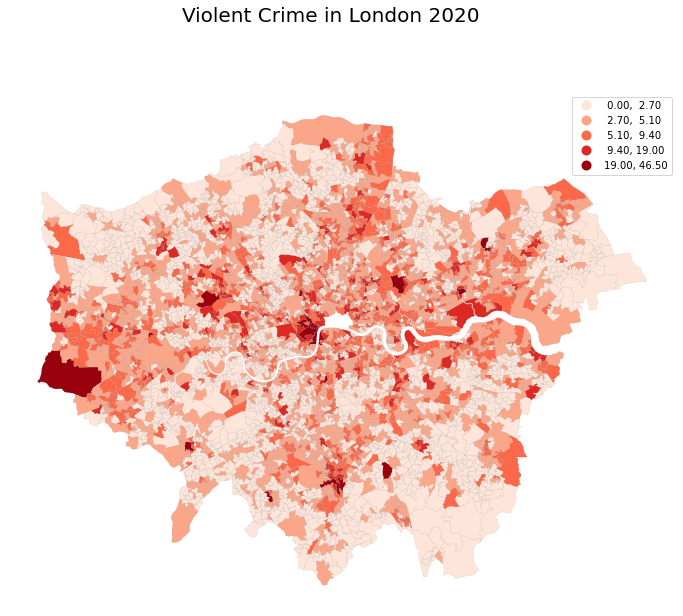

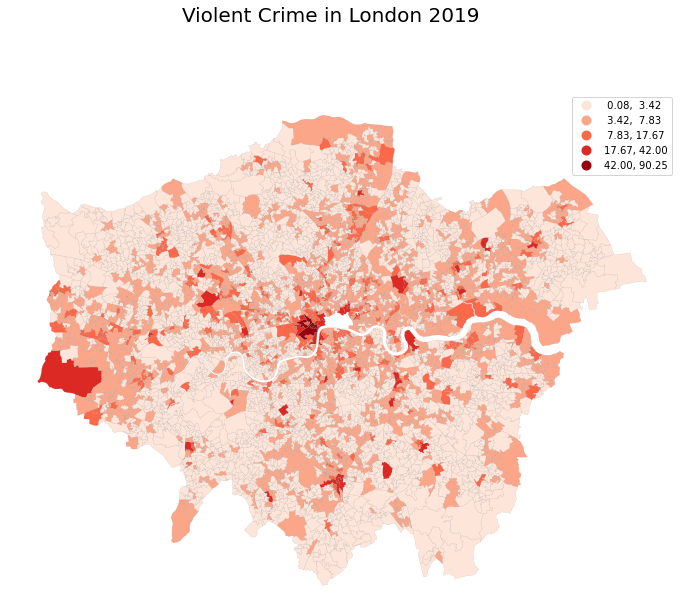

In [64]:
fig, ax1 = plt.subplots(1, figsize=(12,10))
gdf2.plot(ax=ax1, 
         column= 'avg_2021', scheme= 'fisher_jenks', 
        cmap = pcs.Reds_7.mpl_colormap,
        edgecolor='grey', linewidth=0.1,
        legend=True)
plt.suptitle('Violent Crime in London 2021', size=20)
plt.axis('off')
plt.show()

fig, ax1 = plt.subplots(1, figsize=(12,10))
gdf2.plot(ax=ax1, 
         column= 'avg_2020', scheme= 'fisher_jenks',
        cmap = pcs.Reds_7.mpl_colormap,
        edgecolor='grey', linewidth=0.1,
        legend=True)
plt.suptitle('Violent Crime in London 2020', size=20)
plt.axis('off')
plt.show()

fig, ax1 = plt.subplots(1, figsize=(12,10))
gdf2.plot(ax=ax1, 
         column= 'avg_2019', scheme= 'fisher_jenks',
        cmap = pcs.Reds_7.mpl_colormap,
        edgecolor='grey', linewidth=0.1,
        legend=True)
plt.suptitle('Violent Crime in London 2019', size=20)
plt.axis('off')
plt.show()